# Lecture 7: Mighty Pandas
## Contents
- [Imports](#section1)
- [Operations of Pandas](#section2)
    - [Method <code>groupby()</code>: split, apply, and combine](#subsection2.1)
    - [Time series data](#subsection2.2)
    - [Vectorized string operations](#subsection2.3)
    - [Pivot table](#subsection2.4)
- [Case studies](#section3)
    - [Case study: Benford's law](#subsection3.1)

## Imports <a id="section1"></a>

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Operations of Pandas <a id="section2"></a>

### Method <code>groupby()</code>: split, apply, and combine <a id="subsection2.1"></a>

<div class="alert alert-block alert-success">
<b>Example 1:</b> The 'condo.csv' dataset contain the prices of condos in Singapore for the past a few years. Find the average values and the sample standard deviations of condo prices in the CCR, RCR, and OCR areas, respectively.
</div>
Based on what we learned in the previous lecture, these descriptive measures can be obtained by calling the methods <code>mean()</code> and <code>std()</code> after we split the overall dataset into three subsets for CCR, RCR, and OCR areas.

In [2]:
data = pd.read_csv('condo.csv')
data.head()

,name,price,unit_price,district_code,segment,type,area,level,remaining_years,date
0,SEASCAPE,4388000,2028,4,CCR,Resale,2164,06 to 10,87.0,Nov-19
1,COMMONWEALTH TOWERS,1300000,1887,3,RCR,Resale,689,16 to 20,93.0,Nov-19
2,THE TRILINQ,1755000,1304,5,OCR,Resale,1346,06 to 10,92.0,Nov-19
3,THE CREST,2085000,2201,3,RCR,Resale,947,01 to 05,92.0,Nov-19
4,THE ANCHORAGE,1848888,1468,3,RCR,Resale,1259,01 to 05,999.0,Nov-19


In [3]:
means = []
stds = []
for segment in data['segment'].unique():            # Iterate all values of segments
    subset = data.loc[data['segment'] == segment]   # Take a subset for one segment
    means.append(subset['price'].mean())            # Append the mean of the subset
    stds.append(subset['price'].std())              # Append the std of the subset

print('Average prices:      ', means)
print('Standard deviations: ', stds)

Average prices:       [3299744.1464656354, 1644209.3758286098, 1129063.018015854]
Standard deviations:  [2751965.0405150605, 796996.1906509064, 371939.0777243931]


The logic of the program above can be summarized as:
1. A <code>for</code> is used to take a subset for each segment: CCR, RCR, and OCR. 
2. The average and standard deviation of each segment is calculated.
3. THe calculated results are appended to the lists <code>means</code> and <code>stds</code>.

These three steps, namely **split**, **apply**, and **combine**, can be unified into the method <code>groupby()</code> of the <code>pandas.DataFrame</code> data structure. The logic of the <code>groupby()</code> can be illustrated by the following graph.

<img src="https://jakevdp.github.io/figures/split-apply-combine.svg" width=550>

More specifically,
1. The **split** step involves breaking up and grouping a <code>pandas.DataFrame</code> object according to the values of a selected variable (or multiple variables).
2. The **apply** step involves computing some function, usually an aggregate (like <code>sum()</code> in the graph), transformation, or filtering, within the individual groups.
3. The **combine** step merges the results of these operations into a Series or data frame.

Such a logic can be used for **Example 1**, where the average values and standard deviations can be calculated by the <code>groupby()</code> method.

In [4]:
price_means = data.groupby('segment')['price'].mean()
price_means

segment
CCR    3.299744e+06
OCR    1.129063e+06
RCR    1.644209e+06
Name: price, dtype: float64

In [5]:
price_stds = data.groupby('segment')['price'].std()
price_stds

segment
CCR    2.751965e+06
OCR    3.719391e+05
RCR    7.969962e+05
Name: price, dtype: float64

The code above splits the dataset according to the values of the <code>segment</code> column, and the methods <code>mean()</code> and <code>std()</code> are applied as the aggregation calculation, then the results are combined into series. In the remaining part of this section, we will focus on the **apply** step, where different types of functions are called to perform **aggregate**, **transformation**, or **filtering** operations for each data group.

#### Aggregations via <code>agg()</code>

In **Example 1**, we have used the functions like <code>sum()</code> and <code>std()</code> to calculate an aggregated result for each group. A a more general way to apply these functions is by using the <code>agg()</code> method, where the input argument can be a function, a string of function names, or a list of such objects. 

In [6]:
funs = ['count', 'median', 'max', 'min']
price_info = data.groupby('segment')['price'].agg(funs)
price_info

,count,median,max,min
segment,,,,
CCR,5107,2450000.0,52000000,560088
OCR,16652,1069590.0,4881708,488000
RCR,10409,1490000.0,19000000,570000


In [7]:
price_info.columns

Index(['count', 'median', 'max', 'min'], dtype='object')

In [8]:
price_info.index

Index(['CCR', 'OCR', 'RCR'], dtype='object', name='segment')

The row indices can be converted into a new column of the data frame by the <code>reset_index()</code> method. 

In [9]:
price_info.reset_index()

,segment,count,median,max,min
0,CCR,5107,2450000.0,52000000,560088
1,OCR,16652,1069590.0,4881708,488000
2,RCR,10409,1490000.0,19000000,570000


The aggregation operations can also be applied to multiple columns, such as the code below calculate some measures for columns <code>price</code> and <code>area</code>.

In [10]:
funs = ['count', 'median', 'max', 'min']
price_area_info = data.groupby('segment')[['price', 'area']].agg(funs)
price_area_info

price                                area                    
         count     median       max     min  count  median    max  min
segment                                                               
CCR       5107  2450000.0  52000000  560088   5107  1399.0  11098  420
OCR      16652  1069590.0   4881708  488000  16652  1055.0   4876  355
RCR      10409  1490000.0  19000000  570000  10409  1012.0   7987  388

Please note that in the resultant data frame, column indices are formatted as a <code>MultiIndex</code> type object. It can be considered as all combinations of two layers of indices.

In [11]:
price_area_info.columns

MultiIndex([('price',  'count'),
            ('price', 'median'),
            ('price',    'max'),
            ('price',    'min'),
            ( 'area',  'count'),
            ( 'area', 'median'),
            ( 'area',    'max'),
            ( 'area',    'min')],
           )

Another useful syntax of the <code>agg()</code> method is to pass a dictionary mapping column names to operations to be applied on that column. An example is given below.

In [12]:
mapping = {'price': 'mean',         # Average of the prices
           'area': ['min', 'max']}  # Min and max values of condo sizes
mean_median = data.groupby('segment').agg(mapping)
mean_median

price area       
                 mean  min    max
segment                          
CCR      3.299744e+06  420  11098
OCR      1.129063e+06  355   4876
RCR      1.644209e+06  388   7987

It is also possible to use a user-defined function for aggregation operation, as the following example.

In [13]:
def iqr(x):
    
    return x.quantile(0.75) - x.quantile(0.25)

price_iqr = data.groupby('segment')['price'].agg(iqr)
price_iqr

segment
CCR    2010000.0
OCR     470000.0
RCR     708800.0
Name: price, dtype: float64

In this code cell, we defined a function <code>iqr()</code> to calculate the interquartile range (IQR) for each region segment. This function can also be replaced by a small anonymous <code>lambda()</code> function, which is typically used to return the result expressed by a single-line statement. The syntax of the <code>lambda()</code> function is given below.

<img src="https://www.educative.io/api/edpresso/shot/6565495459282944/image/6707306488135680" width=600>

Following the syntax rules, the IQR values can be calculated without formally defining a function, yet the result is the same.

In [14]:
price_iqr = data.groupby('segment')['price'].agg(lambda x: 
                                                 x.quantile(0.75) - x.quantile(0.25))
price_iqr

segment
CCR    2010000.0
OCR     470000.0
RCR     708800.0
Name: price, dtype: float64

#### Transformation via <code>transform()</code>

You may notice that the aggregation operations summarize each group into one value, so the number of rows of the combined data structure is the same as the number of groups. In some cases, we may need to transform each row of the dataset into other values. Take the normalized prices of each region segment for example, it can be calculated by the following code.

In [15]:
def normalize(x):
    
    return (x - x.min()) / (x.max() - x.min())

price_norm = data.groupby('segment')['price'].transform(normalize)
price_norm

0        0.074415
1        0.039609
2        0.288367
3        0.082203
4        0.069392
           ...   
32163    0.177527
32164    0.076473
32165    0.173430
32166    0.135193
32167    0.027767
Name: price, Length: 32168, dtype: float64

Equivalently, the formal function <code>normalize()</code> can be replaced by the <code>lambda</code> version.

In [16]:
price_norm = data.groupby('segment')['price'].transform(lambda x: 
                                                        (x-x.min())/(x.max()-x.min()))
price_norm

0        0.074415
1        0.039609
2        0.288367
3        0.082203
4        0.069392
           ...   
32163    0.177527
32164    0.076473
32165    0.173430
32166    0.135193
32167    0.027767
Name: price, Length: 32168, dtype: float64

Please note that these operations transform each row of the original dataset into a new row of results, so the new data structure created by the <code>transform()</code> method always has the same number of rows as the original dataset.

#### Aggregation or transformation via <code>apply()</code>

The <code>apply()</code> method is a more general and more flexible version of the <code>agg()</code> or <code>transform()</code> methods. The shape of the returned data structure depends on whether the applied function is for aggregation or transformation. 

In [17]:
# Aggregation operation: IQR
price_iqr = data.groupby('segment')['price'].apply(lambda x: 
                                                   x.quantile(0.75) - x.quantile(0.25))
price_iqr

segment
CCR    2010000.0
OCR     470000.0
RCR     708800.0
Name: price, dtype: float64

In [18]:
# Transformation operation: normalization
price_norm = data.groupby('segment')['price'].apply(lambda x: 
                                                    (x-x.min())/(x.max()-x.min()))
price_norm

0        0.074415
1        0.039609
2        0.288367
3        0.082203
4        0.069392
           ...   
32163    0.177527
32164    0.076473
32165    0.173430
32166    0.135193
32167    0.027767
Name: price, Length: 32168, dtype: float64

#### Filtering via <code>filter()</code>

A filtering operation allows you to drop data based on the group properties. For example, we might want to keep all groups in which the mean price is lower than 1800 dollars per square feet. 

In [19]:
cheap_regions = data.groupby('segment').filter(lambda x: 
                                               x['unit_price'].mean() < 1800)
cheap_regions.reset_index(drop=True, inplace=True)
cheap_regions

,name,price,unit_price,district_code,segment,type,area,level,remaining_years,date
0,COMMONWEALTH TOWERS,1300000,1887,3,RCR,Resale,689,16 to 20,93.0,Nov-19
1,THE TRILINQ,1755000,1304,5,OCR,Resale,1346,06 to 10,92.0,Nov-19
2,THE CREST,2085000,2201,3,RCR,Resale,947,01 to 05,92.0,Nov-19
3,THE ANCHORAGE,1848888,1468,3,RCR,Resale,1259,01 to 05,999.0,Nov-19
4,MOUNT FABER LODGE,4400000,1188,4,RCR,Resale,3703,06 to 10,999.0,Oct-19
...,...,...,...,...,...,...,...,...,...,...
27056,SKIES MILTONIA,1268000,1178,27,OCR,Resale,1076,11 to 15,95.0,Nov-16
27057,SYMPHONY SUITES,824000,1034,27,OCR,New Sale,797,06 to 10,97.0,Nov-16
27058,SELETARIS,1250000,754,27,OCR,Resale,1658,01 to 05,999.0,Nov-16
27059,RIVERBANK @ FERNVALE,1082000,1026,28,OCR,New Sale,1055,16 to 20,96.0,Nov-16


It can be seen that the whole group of CCR condos are dropped because the average price for that region is larger than 1800 dollars per square feet. We can use the following code to verify the CCR segment is dropped. 

In [20]:
cheap_regions['segment'].value_counts()

OCR    16652
RCR    10409
Name: segment, dtype: int64

### Time series data <a id="subsection2.2"></a>

<div class="alert alert-block alert-success">
<b>Example 2:</b> Create a new dataset with all condo transactions from January 2018 to June 2018. 
</div>

In the condo price dataset, we have a column <code>date</code> representing the dates of transactions. Values in this column are <code>str</code> type objects, so they cannot be directly used for date selections. 

In [21]:
date = data['date']
date[0]

'Nov-19'

Python provides a new data type called <code>timestamp</code> for easy time and date operations. We can create a new column called <code>time_stamp</code> to store the date data. 

In [22]:
data['time_stamp'] = pd.to_datetime(data['date'], format='%b-%y')
data.head()

,name,price,unit_price,district_code,segment,type,area,level,remaining_years,date,time_stamp
0,SEASCAPE,4388000,2028,4,CCR,Resale,2164,06 to 10,87.0,Nov-19,2019-11-01
1,COMMONWEALTH TOWERS,1300000,1887,3,RCR,Resale,689,16 to 20,93.0,Nov-19,2019-11-01
2,THE TRILINQ,1755000,1304,5,OCR,Resale,1346,06 to 10,92.0,Nov-19,2019-11-01
3,THE CREST,2085000,2201,3,RCR,Resale,947,01 to 05,92.0,Nov-19,2019-11-01
4,THE ANCHORAGE,1848888,1468,3,RCR,Resale,1259,01 to 05,999.0,Nov-19,2019-11-01


The conversion con be performed by the function <code>to_datetime</code>, where the first argument is a series of <code>str</code> type values, and the argument <code>format</code> specify how the stirng is interpreted as time information. You may use the website [here](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) to find other date or time formats. 

The new column is recognized by Python as time data, so we can use the simple logical operators to select data within the time range. 

In [23]:
time_range = pd.to_datetime(['Jan-18', 'Jul-18'], format='%b-%y')
time_range

DatetimeIndex(['2018-01-01', '2018-07-01'], dtype='datetime64[ns]', freq=None)

In [24]:
subset = data.loc[(data['time_stamp'] >= time_range[0]) &
                  (data['time_stamp'] < time_range[1])]
subset

,name,price,unit_price,district_code,segment,type,area,level,remaining_years,date,time_stamp
956,BLUE HORIZON,958000,1035,5,OCR,Resale,926,16 to 20,81.0,Jun-18,2018-06-01
957,THE CREST,3444000,2000,3,RCR,Resale,1722,01 to 05,93.0,Jun-18,2018-06-01
958,ECHELON,1540000,2104,3,RCR,Resale,732,31 to 35,93.0,Jun-18,2018-06-01
959,THE CREST,2495000,2088,3,RCR,Resale,1195,06 to 10,93.0,Jun-18,2018-06-01
960,THE METROPOLITAN CONDOMINIUM,2300000,1327,3,RCR,Resale,1733,06 to 10,87.0,Jun-18,2018-06-01
...,...,...,...,...,...,...,...,...,...,...,...
31247,SYMPHONY SUITES,1015000,993,27,OCR,New Sale,1023,06 to 10,95.0,Jan-18,2018-01-01
31248,THE GREENWICH,635000,1053,28,OCR,Resale,603,01 to 05,90.0,Jan-18,2018-01-01
31249,SYMPHONY SUITES,1000000,1093,27,OCR,New Sale,915,11 to 15,95.0,Jan-18,2018-01-01
31250,KANDIS RESIDENCE,673000,1389,27,OCR,New Sale,484,01 to 05,97.0,Jan-18,2018-01-01


In [25]:
subset = data.loc[(data['time_stamp'] >= time_range[0]) &
                  (data['time_stamp'] < time_range[1])]
subset.reset_index(drop=True, inplace=True)
subset

,name,price,unit_price,district_code,segment,type,area,level,remaining_years,date,time_stamp
0,BLUE HORIZON,958000,1035,5,OCR,Resale,926,16 to 20,81.0,Jun-18,2018-06-01
1,THE CREST,3444000,2000,3,RCR,Resale,1722,01 to 05,93.0,Jun-18,2018-06-01
2,ECHELON,1540000,2104,3,RCR,Resale,732,31 to 35,93.0,Jun-18,2018-06-01
3,THE CREST,2495000,2088,3,RCR,Resale,1195,06 to 10,93.0,Jun-18,2018-06-01
4,THE METROPOLITAN CONDOMINIUM,2300000,1327,3,RCR,Resale,1733,06 to 10,87.0,Jun-18,2018-06-01
...,...,...,...,...,...,...,...,...,...,...,...
6204,SYMPHONY SUITES,1015000,993,27,OCR,New Sale,1023,06 to 10,95.0,Jan-18,2018-01-01
6205,THE GREENWICH,635000,1053,28,OCR,Resale,603,01 to 05,90.0,Jan-18,2018-01-01
6206,SYMPHONY SUITES,1000000,1093,27,OCR,New Sale,915,11 to 15,95.0,Jan-18,2018-01-01
6207,KANDIS RESIDENCE,673000,1389,27,OCR,New Sale,484,01 to 05,97.0,Jan-18,2018-01-01


In [26]:
data['date'].unique()

array(['Nov-19', 'Oct-19', 'Sep-19', 'Aug-19', 'Jul-19', 'Jun-19',
       'May-19', 'Apr-19', 'Mar-19', 'Feb-19', 'Jan-19', 'Dec-18',
       'Nov-18', 'Oct-18', 'Sep-18', 'Aug-18', 'Jul-18', 'Jun-18',
       'May-18', 'Apr-18', 'Mar-18', 'Feb-18', 'Jan-18', 'Dec-17',
       'Nov-17', 'Oct-17', 'Sep-17', 'Aug-17', 'Jul-17', 'Jun-17',
       'May-17', 'Apr-17', 'Mar-17', 'Feb-17', 'Jan-17', 'Dec-16',
       'Nov-16'], dtype=object)

### Vectorized string operations <a id="subsection2.3"></a>
<div class="alert alert-block alert-success">
    <b>Example 3:</b> Notice that the condo level is given as a string "XX to YY". Create two columns <b>level_from</b> and <b>level_to</b>, that are the level numbers "XX" and "YY", as <b>int</b> type values.
</div>

Pandas enables vectorized operations by the <code>str</code> attribute, so that we can apply string methods and indexing or slicing expressions to each string in the series. For example, we may use the <code>lower()</code> method to convert the names of all condo projects to be lower case.

In [27]:
data['name'].str.lower()

0                    seascape
1         commonwealth towers
2                 the trilinq
3                   the crest
4               the anchorage
                 ...         
32163          skies miltonia
32164         symphony suites
32165               seletaris
32166    riverbank @ fernvale
32167             the estuary
Name: name, Length: 32168, dtype: object

The level numbers in **Example 3** can be retrieved by slicing expression of strings, and can be then converted to <code>int</code> type values by the <code>astype()</code> method.

In [28]:
data['level_from'] = data['level'].str[:2].astype(int)
data['level_to'] = data['level'].str[-2:].astype(int)
data.head(6)

,name,price,unit_price,district_code,segment,type,area,level,remaining_years,date,time_stamp,level_from,level_to
0,SEASCAPE,4388000,2028,4,CCR,Resale,2164,06 to 10,87.0,Nov-19,2019-11-01,6,10
1,COMMONWEALTH TOWERS,1300000,1887,3,RCR,Resale,689,16 to 20,93.0,Nov-19,2019-11-01,16,20
2,THE TRILINQ,1755000,1304,5,OCR,Resale,1346,06 to 10,92.0,Nov-19,2019-11-01,6,10
3,THE CREST,2085000,2201,3,RCR,Resale,947,01 to 05,92.0,Nov-19,2019-11-01,1,5
4,THE ANCHORAGE,1848888,1468,3,RCR,Resale,1259,01 to 05,999.0,Nov-19,2019-11-01,1,5
5,MOUNT FABER LODGE,4400000,1188,4,RCR,Resale,3703,06 to 10,999.0,Oct-19,2019-10-01,6,10


<div class="alert alert-block alert-success">
<b>Example 4:</b> Considering Singapore condos in the district 5, use data visualization to show the monthly trends of 1) the average unit prices; and 2) the number of transactions, in recent years. 
</div>
The subset of data for district 5 is obtained by the following code.

In [29]:
subset = data.loc[(data['district_code']==5)]
subset.head(6)

,name,price,unit_price,district_code,segment,type,area,level,remaining_years,date,time_stamp,level_from,level_to
2,THE TRILINQ,1755000,1304,5,OCR,Resale,1346,06 to 10,92.0,Nov-19,2019-11-01,6,10
6,BLUE HORIZON,990000,1022,5,OCR,Resale,969,21 to 25,80.0,Oct-19,2019-10-01,21,25
7,DOVER PARKVIEW,1088000,1162,5,RCR,Resale,936,06 to 10,73.0,Oct-19,2019-10-01,6,10
10,WESTCOVE CONDOMINIUM,970000,834,5,OCR,Resale,1163,01 to 05,75.0,Oct-19,2019-10-01,1,5
14,FABER CREST,950000,919,5,OCR,Resale,1033,01 to 05,76.0,Oct-19,2019-10-01,1,5
15,HERITAGE VIEW,1575000,1199,5,RCR,Resale,1313,16 to 20,76.0,Oct-19,2019-10-01,16,20


The monthly aggregated values can be calculated by the <code>groupby()</code> method.

In [30]:
monthly = subset.groupby('date')['unit_price'].agg(['mean', 'count'])
monthly.reset_index(inplace=True)
monthly.head(10)

,date,mean,count
0,Apr-17,1162.106195,113
1,Apr-18,1151.673913,46
2,Apr-19,1197.903226,31
3,Aug-17,1174.113924,79
4,Aug-18,1244.913043,23
5,Aug-19,1255.642857,14
6,Dec-16,1141.553191,47
7,Dec-17,1197.726027,73
8,Dec-18,1226.526316,19
9,Feb-17,1237.646739,184


You may notice that these records are sorted alphabetically with respect to the strings of the <code>date</code> column. We then convert these strings into <code>timestamp</code> objects, so they can be correctly sorted according to the dates. 

In [31]:
monthly['time_stamp'] = pd.to_datetime(monthly['date'], format='%b-%y')
monthly.head(10)

,date,mean,count,time_stamp
0,Apr-17,1162.106195,113,2017-04-01
1,Apr-18,1151.673913,46,2018-04-01
2,Apr-19,1197.903226,31,2019-04-01
3,Aug-17,1174.113924,79,2017-08-01
4,Aug-18,1244.913043,23,2018-08-01
5,Aug-19,1255.642857,14,2019-08-01
6,Dec-16,1141.553191,47,2016-12-01
7,Dec-17,1197.726027,73,2017-12-01
8,Dec-18,1226.526316,19,2018-12-01
9,Feb-17,1237.646739,184,2017-02-01


In [1]:
monthly.sort_values(by='time_stamp', inplace=True)
monthly.reset_index(drop=True, inplace=True)
monthly.head(10)

NameError: name 'monthly' is not defined

Now we have collected all data we need, the monthly average unit prices and the transaction counts can be visualized as follows.

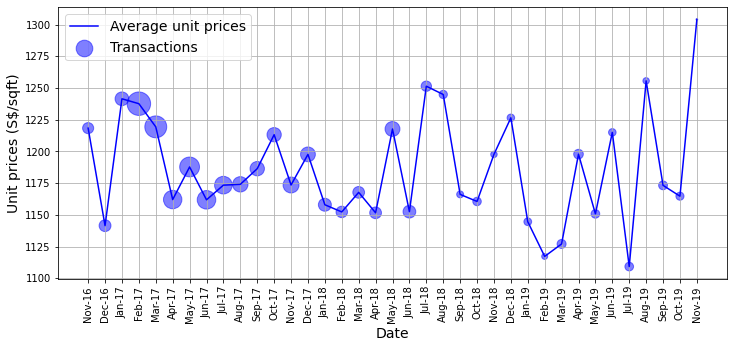

In [33]:
plt.figure(figsize=(12, 5))                          # Resize the figure
plt.plot(monthly['date'], monthly['mean'], 
         c='b', label='Average unit prices')
plt.scatter(monthly['date'], monthly['mean'], 
            s=3*monthly['count'], 
            c='b', alpha=0.5, label='Transactions')

plt.legend(fontsize=14)
plt.xticks(rotation=90)                             # Rotate x ticks
plt.xlabel('Date', fontsize=14)                     # X label and change the font size
plt.ylabel('Unit prices (S$/sqft)', fontsize=14)    # Y label and change the font size
plt.grid()
plt.show()

### Pivot table <a id="subsection2.4"></a>
<div class="alert alert-block alert-success">
<b>Example 5:</b> The "titanic" dataset provides a sample data of passengers of RMS Titanic. Explore the percentage of survival by sex and classes.   
</div>

In [34]:
data_titan = pd.read_csv('titanic.csv')
data_titan.head(6)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True


We may use the <code>groupby()</code> method to obtain the survival rates for both genders and various classes.

In [35]:
srate = data_titan.groupby(['sex', 'class'])['survived'].aggregate('mean')
srate

sex     class 
female  First     0.968085
        Second    0.921053
        Third     0.500000
male    First     0.368852
        Second    0.157407
        Third     0.135447
Name: survived, dtype: float64

Please note that the row indices of the series above have two layers, containing all combinations of values of <code>sex</code> and <code>class</code>.

In [36]:
srate.index

MultiIndex([('female',  'First'),
            ('female', 'Second'),
            ('female',  'Third'),
            (  'male',  'First'),
            (  'male', 'Second'),
            (  'male',  'Third')],
           names=['sex', 'class'])

The inner layer of indices can be used as column labels to form transform the series into a data frame by the <code>unstack()</code> method, as the code below.

In [37]:
srate = data_titan.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()
srate

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


The data frame provides a better presentation of the survival rates by both genders and different classes. However, such a long line of code is not easy to implement, so an equivalent approach using the <code>pivot_table()</code> method is introduced below.

In [38]:
srate = data_titan.pivot_table('survived', index='sex', columns='class')
srate

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Obviously, if we want to use <code>class</code> as row indices, and <code>sex</code> as column indices, then the code is given below.

In [39]:
srate = data_titan.pivot_table('survived', columns='sex', index='class')
srate.columns.name = None   # Remove the name of column indices
srate.index.name = None     # Remove the name of row indices
srate

,female,male
First,0.968085,0.368852
Second,0.921053,0.157407
Third,0.500000,0.135447


When multiple variables are used for column or row indices, there will be multi-layer indices. For example, we may use the function <code>cut()</code> to create age intervals for passengers. 

In [40]:
age = pd.cut(data_titan['age'], [0, 18, 50, 80])
age

0      (18.0, 50.0]
1      (18.0, 50.0]
2      (18.0, 50.0]
3      (18.0, 50.0]
4      (18.0, 50.0]
           ...     
886    (18.0, 50.0]
887    (18.0, 50.0]
888             NaN
889    (18.0, 50.0]
890    (18.0, 50.0]
Name: age, Length: 891, dtype: category
Categories (3, interval[int64, right]): [(0, 18] < (18, 50] < (50, 80]]

The variable <code>age</code> can be used as a row index for pivoting the table, as the following code.

In [41]:
srate = data_titan.pivot_table('survived', index=['sex', age], columns='class')
srate

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 50]  0.967213  0.912281  0.413793
       (50, 80]  1.000000  0.666667  1.000000
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 50]  0.442857  0.069444  0.139896
       (50, 80]  0.192308  0.083333  0.000000

In all example above, we are using the default setting of the aggregation function, which is to take the mean of the selected column <code>survived</code>. You may implement other aggregation function by specifying the argument <code>aggfunc</code> of the <code>pivot_table()</code> method.

## Case Studies <a id="section3"></a>

### Case Study 1: Benford's law <a id="subsection3.1"></a>

Consider a naturally occurring collection of numbers, such as the GDP of all countries in a given year, or the financial data of a company, what is the distribution of the first digit of these numbers? 

Our first intuition may tell us that all digits should have equal probability to appear, thus following a uniform distribution. However, the [Benford's law](https://en.wikipedia.org/wiki/Benford%27s_law) suggests that smaller digits have a higher probability to occur. Let $d$ be the first digit, then the occurring probability $p$ can be approximately expressed by
$$
p = \log_{10}\left(1 + \frac{1}{d}\right), ~~ d=1, 2, ..., 9
$$

In this exercise, we are using data visualization to verify that the GDP of different countries in a particular year roughly follows the equation given by the Benford's law. 


In [42]:
gdp = pd.read_csv('gdp.csv')            # Read the dataset
gdp.head(6)

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.498883e+09,2.390503e+09,2.549721e+09,2.534637e+09,2.581564e+09,2.649721e+09,2.691620e+09,2.646927e+09,2.700559e+09,NaN
1,Afghanistan,AFG,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,1.400000e+09,1.673333e+09,...,1.243909e+10,1.585657e+10,1.780428e+10,2.000162e+10,2.056105e+10,2.048487e+10,1.990711e+10,1.936264e+10,2.019176e+10,1.936297e+10
2,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.030716e+10,8.379950e+10,1.117897e+11,1.280529e+11,1.367099e+11,1.457122e+11,1.161936e+11,1.011239e+11,1.221238e+11,1.057510e+11
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.204422e+10,1.192696e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.186135e+10,1.302506e+10,1.510250e+10
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.013387e+09,3.236544e+09
5,United Arab Emirates,ARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.535474e+11,2.897873e+11,3.506660e+11,3.745906e+11,3.901076e+11,4.031371e+11,3.581351e+11,3.570451e+11,3.777011e+11,4.141789e+11


In [43]:
gdp.columns

Index(['Country Name', 'Country Code', '1960', '1961', '1962', '1963', '1964',
       '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982',
       '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'],
      dtype='object')

#### Select relevant subset of data

In [44]:
year = 2001                             # Choose a year
gdp_yearly = gdp[str(year)].dropna()
gdp_yearly

0      1.920112e+09
2      8.936064e+09
3      3.922099e+09
4      1.496913e+09
5      1.033116e+11
           ...     
210    2.730884e+08
211    9.861560e+09
212    1.215147e+11
213    4.094481e+09
214    6.777385e+09
Name: 2001, Length: 196, dtype: float64

In the code cell above, we select one year from the dataset. Please note that the GDP for some countries are missing, and these missing values are replaced by zeros. As a result, we are using boolean indexing to remove these missing values.

#### Counts of the first digit of GDP numbers
The next step is to retrieve the first digit of the GDP numbers. Firstly, we convert the GDP numbers to strings by the <code>astype()</code> method. 

Based on the series <code>first_digit</code>, we can obtain the number (or percentage) of occurrences of these digits by using the method <code>value_counts()</code>. Details of this method can be found [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html). 

In [ ]:
first_digital.value_count(normalize=True)

#### The Benford's law distribution

In this section, we use the equation of Benford's law to calculate the corresponding probability <code>p</code> for all possible first digits <code>d</code>. Note that <code>d</code> can be written as an array running from 1 to 9, and the probability <code>p</code> can be calculated by applying the equation to all elements in the array.

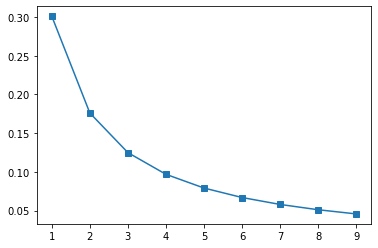

In [6]:
 
d = np.arange(1,10,1)
p = np.log10(1+1/d)
plt.plot(d,p,marker='s')

#### Verify the Benford's law via data visualization

Please plot 1) the curve of the theoretical probability distribution given by the Benford's law; and 2) the actual distribution of the first digit of GDP numbers, in the same chart, so that we can compare the two for verifying the Benford's law. 

用plt.fill_between去填充

In [ ]:
plt.plot(d,gdp_p[d], linestyle=':', color='k', marker='o', markerfacecolor)
plt.fill_between(d, y1=[0]*9, y2=p, color='orange', alpha=0.6, label="Benford's law")
plt.legend()
plt.xlabel('First digits')
plt.ylabel('Percentage Occurance')
plt.show()

You may change the selected years and rerun the program above, you would find that each bar graph roughly matches the Benford's law curve. You are encourage to download other natural number datasets, such as the global population or the financial data for some companies, to further verify this law. 

In fact, the Benford's law was once used to detect the fraudulent financial data of Enron in 2000.

<img src="https://si.wsj.net/public/resources/images/NA-CD776_NUMBER_9U_20141205130308.jpg" width=600pt>

